# EDA COMPLETO - ISIC 2018 (Train + Validation + Test)

## Objetivos:
1. Analizar distribución y características de los 3 conjuntos
2. Verificar consistencia entre imágenes y máscaras
3. Identificar potenciales problemas para el preprocesamiento


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Configurar rutas
BASE_PATH = Path("../data/raw")

DATASETS = {
    "train": {
        "images": BASE_PATH / "isic_2018_train/images",
        "masks": BASE_PATH / "isic_2018_train/masks"
    },
    "val": {
        "images": BASE_PATH / "isic_2018_val/images",
        "masks": BASE_PATH / "isic_2018_val/masks"
    },
    "test": {
        "images": BASE_PATH / "isic_2018_test/images",
        "masks": BASE_PATH / "isic_2018_test/masks",
    }
}

print("Verificando estructura de directorios...")
for name, paths in DATASETS.items():
    print(f"\n{name.upper()}:")
    print(f"  Imágenes: {paths['images'].exists()} ({len(list(paths['images'].glob('*.jpg')))} archivos)")
    if paths['masks']:
        print(f"  Máscaras: {paths['masks'].exists()} ({len(list(paths['masks'].glob('*.png')))} archivos)")
    else:
        print(f"  Máscaras: No disponible")

Verificando estructura de directorios...

TRAIN:
  Imágenes: True (2594 archivos)
  Máscaras: True (2594 archivos)

VAL:
  Imágenes: True (100 archivos)
  Máscaras: True (100 archivos)

TEST:
  Imágenes: True (1000 archivos)
  Máscaras: True (1000 archivos)


## 1. ANÁLISIS COMPARATIVO ENTRE CONJUNTOS

In [3]:
def get_dataset_stats(dataset_name, dataset_paths):
    """Obtiene estadísticas de un conjunto de datos"""
    
    stats = {
        "name": dataset_name,
        "total_images": 0,
        "total_masks": 0,
        "heights": [],
        "widths": [],
        "channels": [],
        "image_sizes_mb": [],
        "mask_sizes_mb": [],
        "pixel_intensity_means": [],
        "mask_coverage": []  # Solo para conjuntos con máscaras
    }
    
    # Analizar imágenes
    image_files = list(dataset_paths['images'].glob("*.jpg"))
    stats["total_images"] = len(image_files)
    
    # Muestrear para análisis intensivo
    
    for img_path in image_files:
        # Estadísticas de imagen
        img = cv2.imread(str(img_path))
        if img is not None:
            h, w, c = img.shape
            stats["heights"].append(h)
            stats["widths"].append(w)
            stats["channels"].append(c)
            stats["image_sizes_mb"].append(os.path.getsize(img_path) / (1024*1024))
            
            # Intensidad media de píxeles
            stats["pixel_intensity_means"].append(img.mean())
    
    # Analizar máscaras si existen
    if dataset_paths['masks']:
        mask_files = list(dataset_paths['masks'].glob("*.png"))
        stats["total_masks"] = len(mask_files)
        
        for mask_path in mask_files[:min(len(image_files), len(mask_files))]:
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            stats["mask_sizes_mb"].append(os.path.getsize(mask_path) / (1024*1024))
                
            # Calcular cobertura (porcentaje de píxeles de lesión)
            mask_normalized = mask / 255.0 if mask.max() > 1 else mask
            coverage = mask_normalized.sum() / mask_normalized.size
            stats["mask_coverage"].append(coverage)
    
    return stats

In [4]:
# Calcular estadísticas para los 3 conjuntos
print("📊 Calculando estadísticas...")
all_stats = {}

for name, paths in DATASETS.items():
    print(f"  Analizando {name}...")
    all_stats[name] = get_dataset_stats(name, paths)

📊 Calculando estadísticas...
  Analizando train...
  Analizando val...
  Analizando test...


In [17]:
# Crear DataFrame comparativo
comparison_data = []

for name, stats in all_stats.items():
    comparison_data.append({
        "Dataset": name.upper(),
        "Imágenes": stats["total_images"],
        "Máscaras": stats["total_masks"],
        "Altura Media": np.mean(stats["heights"]) if stats["heights"] else 0,
        "Ancho Medio": np.mean(stats["widths"]) if stats["widths"] else 0,
        "Tamaño Img (MB)": np.mean(stats["image_sizes_mb"]) if stats["image_sizes_mb"] else 0,
        "Intensidad Media": np.mean(stats["pixel_intensity_means"]) if stats["pixel_intensity_means"] else 0,
        "Cobertura Media": np.mean(stats["mask_coverage"]) if stats["mask_coverage"] else 0,
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n📋 RESUMEN COMPARATIVO:")
display(df_comparison)


📋 RESUMEN COMPARATIVO:


,Dataset,Imágenes,Máscaras,Altura Media,Ancho Medio,Tamaño Img (MB),Intensidad Media,Cobertura Media
0,TRAIN,2594,2594,2166.791442,3188.266384,4.123502,155.261986,0.214021
1,VAL,100,100,1775.800000,2448.830000,2.286265,148.360084,0.268481
2,TEST,1000,1000,1850.575000,2529.909000,2.264578,148.102759,0.279850


## 2. VISUALIZACIÓN COMPARATIVA

In [18]:
# Figura 1: Distribución de dimensiones
fig1 = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Distribución de Alturas", "Distribución de Anchuras")
)

colors = {'train': 'blue', 'val': 'green', 'test': 'red'}

for name, stats in all_stats.items():
    if stats["heights"]:
        fig1.add_trace(
            go.Histogram(x=stats["heights"], name=f"{name.upper()}", 
                        marker_color=colors[name], opacity=0.7),
            row=1, col=1
        )
        fig1.add_trace(
            go.Histogram(x=stats["widths"], name=f"{name.upper()}", 
                        marker_color=colors[name], opacity=0.7, showlegend=False),
            row=1, col=2
        )

fig1.update_layout(title_text="Comparación de Dimensiones entre Conjuntos", 
                   barmode='overlay')
fig1.show()

In [19]:
# Figura 2: Intensidad de píxeles y cobertura
fig2 = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Intensidad Media de Píxeles", "Cobertura de Máscaras"),
    specs=[[{"type": "box"}, {"type": "box"}]]
)

# Intensidad de píxeles
intensity_data = []
labels = []
for name, stats in all_stats.items():
    if stats["pixel_intensity_means"]:
        intensity_data.append(stats["pixel_intensity_means"])
        labels.append(name.upper())

fig2.add_trace(go.Box(y=intensity_data[0], name=labels[0], marker_color=colors['train']), row=1, col=1)
if len(intensity_data) > 1:
    fig2.add_trace(go.Box(y=intensity_data[1], name=labels[1], marker_color=colors['val']), row=1, col=1)
if len(intensity_data) > 2:
    fig2.add_trace(go.Box(y=intensity_data[2], name=labels[2], marker_color=colors['test']), row=1, col=1)

# Cobertura de máscaras (solo train y val)
coverage_data = []
coverage_labels = []
for name in ['train', 'val', 'test']:
    if all_stats[name]["mask_coverage"]:
        coverage_data.append(all_stats[name]["mask_coverage"])
        coverage_labels.append(name.upper())

if coverage_data:
    fig2.add_trace(go.Box(y=coverage_data[0], name=coverage_labels[0], 
                         marker_color=colors['train']), row=1, col=2)
    if len(coverage_data) > 1:
        fig2.add_trace(go.Box(y=coverage_data[1], name=coverage_labels[1], 
                             marker_color=colors['val']), row=1, col=2)
    if len(coverage_data) > 2:
        fig2.add_trace(go.Box(y=coverage_data[2], name=coverage_labels[2], 
                             marker_color=colors['test']), row=1, col=2)

fig2.update_layout(title_text="Comparación de Características de Imágenes", height=500)
fig2.show()

In [20]:
def check_image_mask_correspondence(images_dir, masks_dir):
    """Verifica que cada imagen tenga su máscara correspondiente"""
    
    image_files = sorted([f.stem for f in images_dir.glob("*.jpg")])
    mask_files = sorted([f.stem.replace('_segmentation', '') for f in masks_dir.glob("*.png")])
    
    missing_masks = set(image_files) - set(mask_files)
    extra_masks = set(mask_files) - set(image_files)
    
    return {
        "total_images": len(image_files),
        "total_masks": len(mask_files),
        "missing_masks": len(missing_masks),
        "extra_masks": len(extra_masks),
        "perfect_match": len(missing_masks) == 0 and len(extra_masks) == 0
    }

In [21]:
print("🔍 Verificando correspondencia imagen-máscara...")
correspondence_results = {}

for name in ['train', 'val', 'test']:
    if DATASETS[name]['masks']:
        result = check_image_mask_correspondence(
            DATASETS[name]['images'], 
            DATASETS[name]['masks']
        )
        correspondence_results[name] = result
        
        print(f"\n{name.upper()}:")
        print(f"  Imágenes: {result['total_images']}")
        print(f"  Máscaras: {result['total_masks']}")

🔍 Verificando correspondencia imagen-máscara...

TRAIN:
  Imágenes: 2594
  Máscaras: 2594

VAL:
  Imágenes: 100
  Máscaras: 100

TEST:
  Imágenes: 1000
  Máscaras: 1000


## 4. VISUALIZACIÓN DE MUESTRAS POR CONJUNTO

In [22]:
def visualize_dataset_samples(dataset_name, n_samples=4):
    """Visualiza muestras aleatorias de un conjunto"""
    
    paths = DATASETS[dataset_name]
    image_files = list(paths['images'].glob("*.jpg"))
    
    if len(image_files) == 0:
        print(f"No hay imágenes en {dataset_name}")
        return
    
    samples = np.random.choice(image_files, min(n_samples, len(image_files)), replace=False)
    
    fig, axes = plt.subplots(2, n_samples, figsize=(4*n_samples, 8))
    fig.suptitle(f"Dataset: {dataset_name.upper()}", fontsize=16, y=1.02)
    
    for i, img_path in enumerate(samples):
        # Cargar imagen
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Mostrar imagen
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"ID: {img_path.stem[:12]}...")
        axes[0, i].axis('off')
        
        # Mostrar máscara si existe
        if paths['masks']:
            mask_path = paths['masks'] / f"{img_path.stem}_segmentation.png"
            if mask_path.exists():
                mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
                axes[1, i].imshow(mask, cmap='gray')
                axes[1, i].set_title(f"Máscara")
                
                # Superposición
                mask_rgb = np.zeros_like(img)
                mask_rgb[:,:,1] = mask
                overlay = cv2.addWeighted(img, 0.7, mask_rgb, 0.3, 0)
                # Podríamos mostrar la superposición en una tercera fila si quisiéramos
            else:
                axes[1, i].text(0.5, 0.5, "Sin máscara", 
                              ha='center', va='center', fontsize=12)
                axes[1, i].set_title("Máscara no encontrada")
        else:
            axes[1, i].text(0.5, 0.5, "Dataset sin máscaras", 
                          ha='center', va='center', fontsize=10)
            axes[1, i].set_title("Test set")
        
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

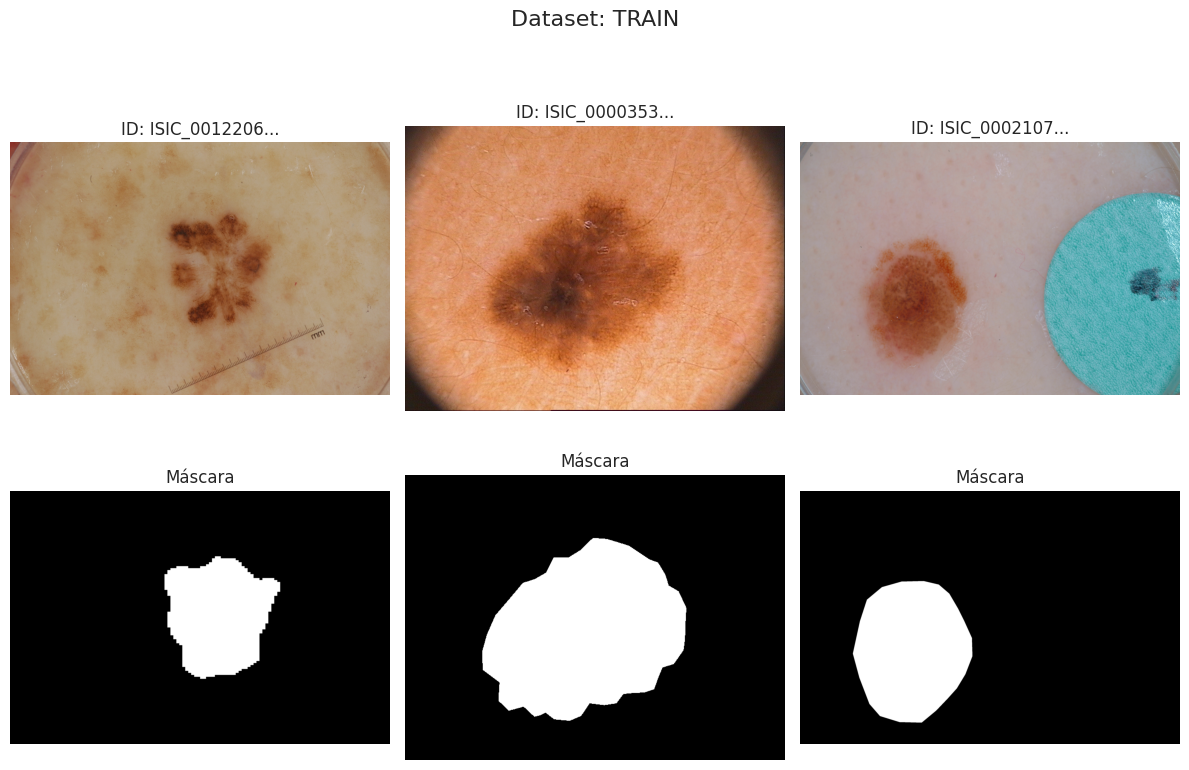

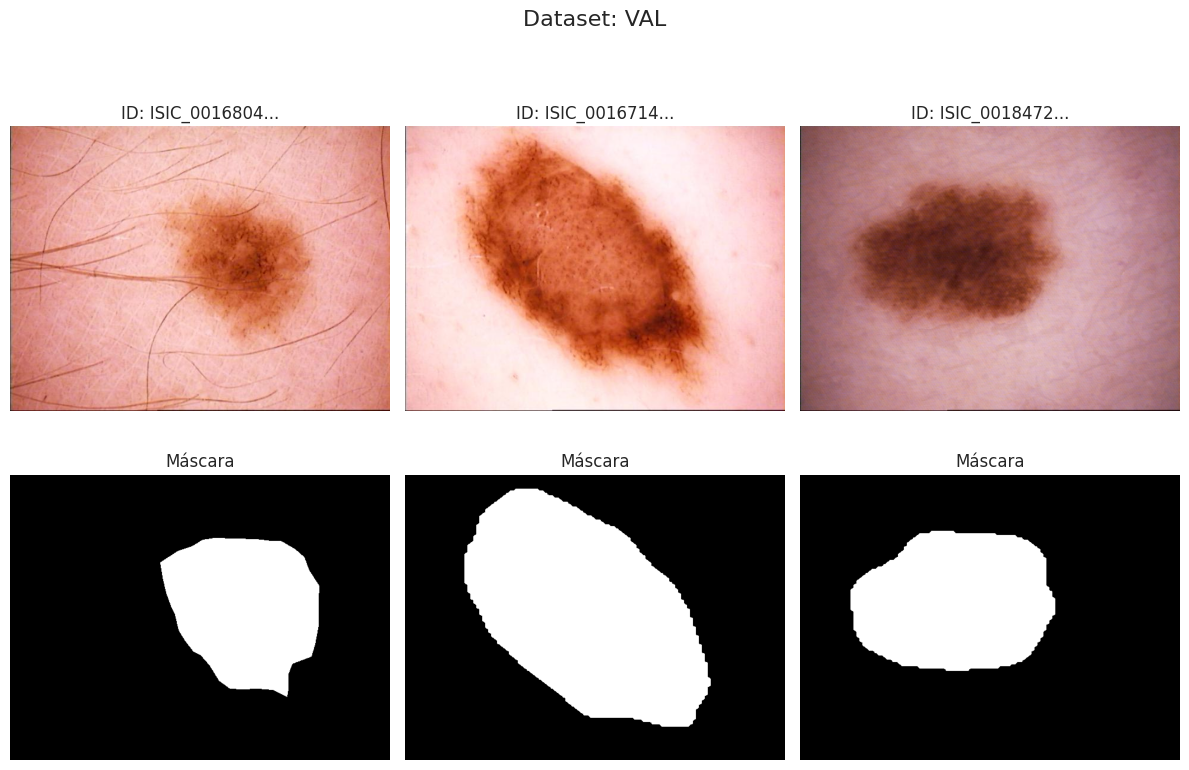

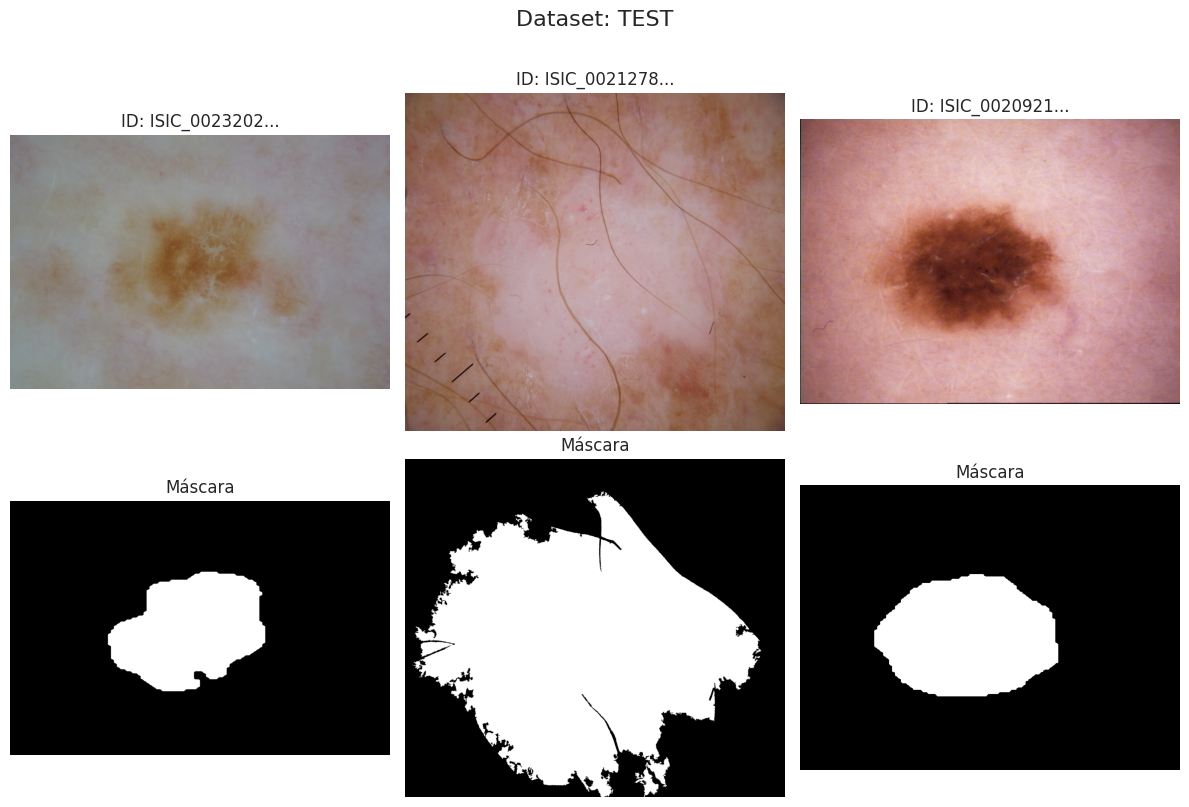

In [23]:
# Visualizar muestras de cada conjunto
for dataset_name in DATASETS.keys():
    visualize_dataset_samples(dataset_name, n_samples=3)

## 5. ANÁLISIS DE CALIDAD DE MÁSCARAS

In [24]:
def analyze_mask_quality(masks_dir, sample_size=50):
    """Analiza la calidad de las máscaras"""
    
    mask_files = list(masks_dir.glob("*.png"))
    if len(mask_files) == 0:
        return None
    
    if sample_size > len(mask_files):
        sample_files = mask_files
    else:
        sample_files = np.random.choice(mask_files, sample_size, replace=False)
    
    qualities = []
    
    for mask_path in sample_files:
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        
        # Normalizar
        mask_binary = (mask > 0).astype(np.uint8)
        
        # Calcular bordes (para ver suavidad)
        edges = cv2.Canny(mask_binary, 0, 1)
        edge_density = edges.sum() / mask.size
        
        # Calcular compacidad (perímetro^2 / área)
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            area = cv2.contourArea(contours[0])
            perimeter = cv2.arcLength(contours[0], True)
            compactness = (perimeter ** 2) / (4 * np.pi * area) if area > 0 else 0
        else:
            compactness = 0
        
        qualities.append({
            "edge_density": edge_density,
            "compactness": compactness,
            "area": mask_binary.sum() / 255
        })
    
    return pd.DataFrame(qualities)


Calidad de máscaras - TRAIN:
  Densidad de bordes media: 0.3671
  Compacidad media: 4.42
  Área media: 9761 píxeles


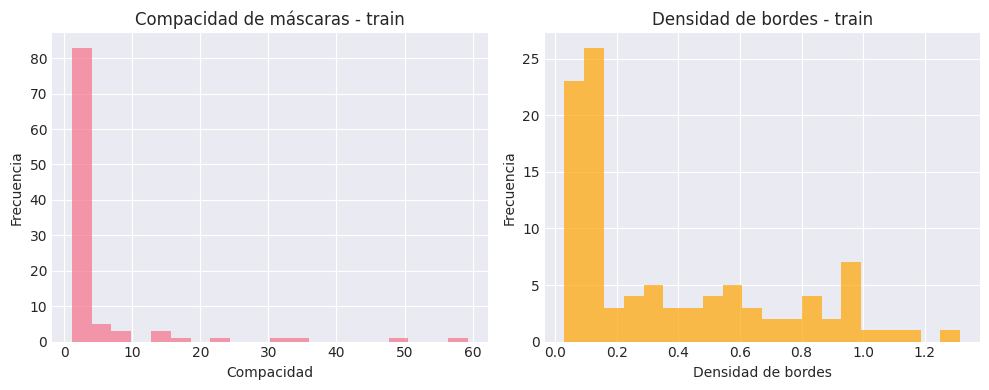


Calidad de máscaras - VAL:
  Densidad de bordes media: 0.4649
  Compacidad media: 2.21
  Área media: 6217 píxeles


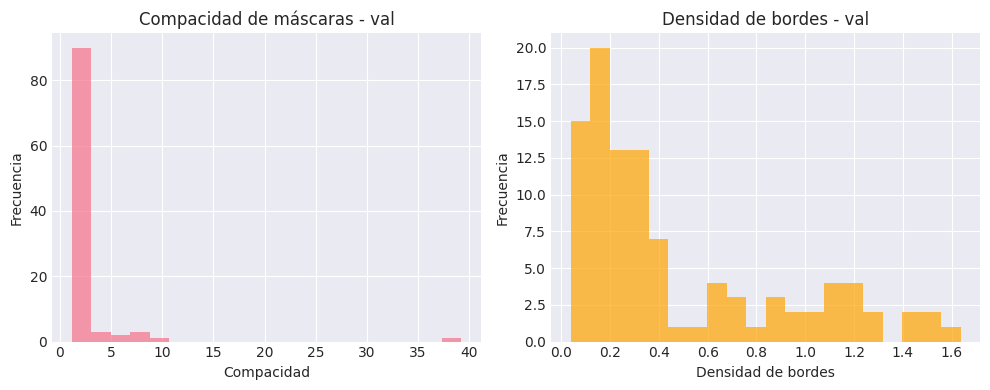


Calidad de máscaras - TEST:
  Densidad de bordes media: 0.5058
  Compacidad media: 3.71
  Área media: 7724 píxeles


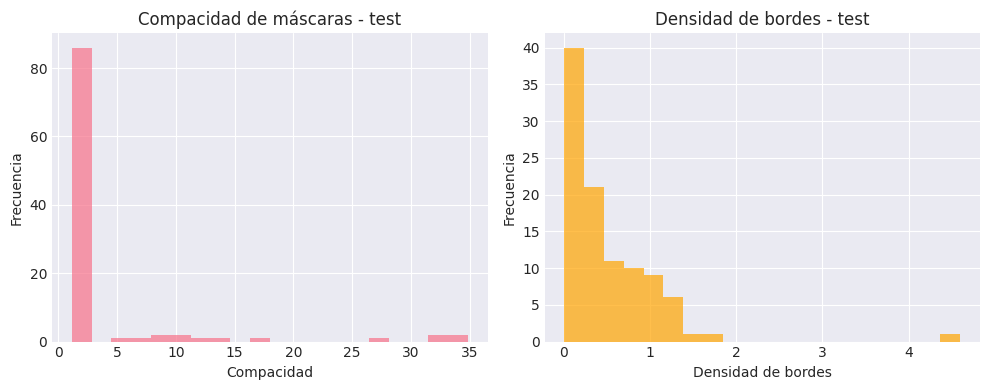

In [25]:
# Analizar calidad de máscaras en train y val
for name in ['train', 'val', 'test']:
    if DATASETS[name]['masks']:
        quality_df = analyze_mask_quality(DATASETS[name]['masks'], sample_size=100)
        
        print(f"\nCalidad de máscaras - {name.upper()}:")
        print(f"  Densidad de bordes media: {quality_df['edge_density'].mean():.4f}")
        print(f"  Compacidad media: {quality_df['compactness'].mean():.2f}")
        print(f"  Área media: {quality_df['area'].mean():.0f} píxeles")
        
        # Histograma de compacidad
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.hist(quality_df['compactness'], bins=20, alpha=0.7)
        plt.xlabel('Compacidad')
        plt.ylabel('Frecuencia')
        plt.title(f'Compacidad de máscaras - {name}')
        
        plt.subplot(1, 2, 2)
        plt.hist(quality_df['edge_density'], bins=20, alpha=0.7, color='orange')
        plt.xlabel('Densidad de bordes')
        plt.ylabel('Frecuencia')
        plt.title(f'Densidad de bordes - {name}')
        
        plt.tight_layout()
        plt.show()

## 6. EXPORTAR RESULTADOS DEL EDA

In [26]:
# Crear directorio para resultados del EDA
eda_results_dir = Path("./experiments/eda_results")
eda_results_dir.mkdir(parents=True, exist_ok=True)

# Guardar DataFrames
df_comparison.to_csv(eda_results_dir / "dataset_comparison.csv", index=False)

# Guardar estadísticas detalladas
import json
with open(eda_results_dir / "detailed_stats.json", "w") as f:
    # Convertir a tipos nativos de Python para JSON
    json_stats = {}
    for name, stats in all_stats.items():
        json_stats[name] = {
            k: (v if not isinstance(v, (np.ndarray, list)) else 
                [float(x) for x in v] if isinstance(v, np.ndarray) else v)
            for k, v in stats.items()
        }
    json.dump(json_stats, f, indent=2)

print(f"\n💾 Resultados guardados en: {eda_results_dir.absolute()}")


💾 Resultados guardados en: /home/salvalago23/tfm_segmentacion/notebooks/experiments/eda_results
